# filter bubble effect (working title)

### #pre import needed packages



In [2]:
#imports

from datetime import date, datetime, timezone
import asyncio
import json
import pandas as pd
pd.options.display.max_colwidth = 400
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import date, datetime, timezone, timedelta
import csv
import re
import researchpy as rp

from twarc import Twarc2 #twitter

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #sentiment vader
sentimentAnalyser = SentimentIntensityAnalyzer() #sentiment vader

### #1 import of members of congress (senators, representatives) and keywords on 'abortion'

* data/us_senators_040722.csv
* data/us_representatives_040722.csv


In [3]:
#file imports (all tweets from filename.csv)
senators = []
representatives = []
keywords=[]

#read
senators=pd.read_csv('data/us_senators_040722.csv', header='infer', sep=";", dtype=str)
representatives=pd.read_csv('data/us_representatives_040722.csv', header='infer', sep=";", dtype=str)

#add twitter handle (extraction from link)
senators['Twitter'] = senators['Link'].str.replace('https://twitter.com/','').str.lower()
representatives['Twitter'] = representatives['Link'].str.replace('https://twitter.com/','').str.lower()

#keyword to list
with open('data/keywords.csv', 'r') as read_keywords:
    next(read_keywords)
    lines = read_keywords.readlines()
    for line in lines:
            line = line.replace("\n", "")
            keywords.append(line)

#prints---------
print("Senators: ", len(senators))
print("Representatives: ",len(representatives))
print()
#print(keywords)
display(senators.head(5))
#display(representatives.head(5))

Senators:  100
Representatives:  436



/var/folders/qh/_dtmnfpx1552ksv4hpb8ly3h0000gn/T/ipykernel_10081/1235593225.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  senators['Twitter'] = senators['Link'].str.replace('https://twitter.com/','').str.lower()
/var/folders/qh/_dtmnfpx1552ksv4hpb8ly3h0000gn/T/ipykernel_10081/1235593225.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  representatives['Twitter'] = representatives['Link'].str.replace('https://twitter.com/','').str.lower()


,Name,Link,State,Party,Twitter
0,"Baldwin, Tammy",https://twitter.com/SenatorBaldwin,WI,Democrat,senatorbaldwin
1,"Barrasso, John",https://twitter.com/SenJohnBarrasso,WY,Republican,senjohnbarrasso
2,"Bennet, Michael F.",https://twitter.com/SenatorBennet,CO,Democrat,senatorbennet
3,"Blackburn, Marsha",https://twitter.com/MarshaBlackburn,TN,Republican,marshablackburn
4,"Blumenthal, Richard",https://twitter.com/SenBlumenthal,CT,Democrat,senblumenthal


### #2 lets focus on senators and process a twitter query

* https://github.com/twitterdev/getting-started-with-the-twitter-api-v2-for-academic-research/blob/main/modules/5-how-to-write-search-queries.md

#### it should include:

* (a)  English as language ("lang:en")
* (b)  members of congress ("from:SENATOR1 OR from:SENATOR2 OR ...")
* (c)  keywords for abortion (list provided by Jana)


!queries for senators are devided in 5 queries due to character size of query!

In [4]:
#query split

#query language and keywords (323 characters)
keywords_str=str("lang:en (abortion OR pregnancies OR pregnancy OR pregnant OR unborn OR embryonic OR pro choice OR pro life OR prochoice OR prolife OR roevwade OR roe v wade OR right to life OR righttolife OR infanticide OR parenthood OR abortions OR embryo OR contraception OR ultrasound OR planned parenthood OR reproductive OR ultrasounds) ")

#senators
all_senators_str=str("(from:SenatorBaldwin OR from:SenJohnBarrasso OR from:SenatorBennet OR from:MarshaBlackburn OR from:SenBlumenthal OR from:RoyBlunt OR from:CoryBooker OR from:JohnBoozman OR from:SenatorBraun OR from:SenSherrodBrown OR from:SenatorBurr OR from:SenatorCantwell OR from:SenCapito OR from:SenatorCardin OR from:SenatorCarper OR from:SenBobCasey OR from:SenBillCassidy OR from:SenatorCollins OR from:ChrisCoons OR from:JohnCornyn OR from:SenCortezMasto OR from:SenTomCotton OR from:SenKevinCramer OR from:MikeCrapo OR from:SenTedCruz OR from:SteveDaines OR from:SenDuckworth OR from:SenatorDurbin OR from:SenJoniErnst OR from:SenFeinstein OR from:SenatorFischer OR from:SenGillibrand OR from:LindseyGrahamSC OR from:ChuckGrassley OR from:SenatorHagerty OR from:SenatorHassan OR from:HawleyMO OR from:MartinHeinrich OR from:SenatorHick OR from:maziehirono OR from:SenJohnHoeven OR from:SenHydeSmith OR from:JimInhofe OR from:SenRonJohnson OR from:timkaine OR from:SenMarkKelly OR from:SenJohnKennedy OR from:SenAngusKing OR from:SenAmyKlobuchar OR from:SenatorLankford OR from:SenatorLeahy OR from:SenMikeLee OR from:SenatorLujan OR from:SenLummis OR from:Sen_JoeManchin OR from:SenMarkey OR from:SenatorMarshall OR from:senatemajldr OR from:SenatorMenendez OR from:SenJeffMerkley OR from:JerryMoran OR from:lisamurkowski OR from:ChrisMurphyCT OR from:PattyMurray OR from:ossoff OR from:SenAlexPadilla OR from:RandPaul OR from:SenGaryPeters OR from:senrobportman OR from:SenJackReed OR from:SenatorRisch OR from:SenatorRomney OR from:SenJackyRosen OR from:SenatorRounds OR from:marcorubio OR from:SenSanders OR from:SenSasse OR from:SenBrianSchatz OR from:SenSchumer OR from:SenRickScott OR from:SenatorTimScott OR from:SenatorShaheen OR from:SenShelby OR from:SenatorSinema OR from:SenTinaSmith OR from:SenStabenow OR from:SenDanSullivan OR from:SenatorTester OR from:SenJohnThune OR from:SenThomTillis OR from:SenToomey OR from:SenTuberville OR from:ChrisVanHollen OR from:MarkWarner OR from:SenatorWarnock OR from:SenWarren OR from:SenWhitehouse OR from:SenatorWicker OR from:RonWyden OR from:SenToddYoung)")

#representatives
all_representatives_str=str("(from:RepAdams OR from:Robert_Aderholt OR from:RepPeteAguilar OR from:RepRickAllen OR from:RepColinAllred OR from:MarkAmodeiNV2 OR from:RepArmstrongND OR from:RepArrington OR from:RepAuchincloss OR from:RepCindyAxne OR from:RepBrianBabin OR from:RepDonBacon OR from:RepJimBaird OR from:RepBalderson OR from:RepJimBanks OR from:RepAndyBarr OR from:RepBarragan OR from:RepKarenBass OR from:RepBeatty OR from:RepBentz OR from:RepBera OR from:RepJackBergman OR from:RepDonBeyer OR from:RepBice OR from:RepAndyBiggsAZ OR from:RepGusBilirakis OR from:SanfordBishop OR from:RepDanBishop OR from:repblumenauer OR from:RepLBR OR from:RepBoebert OR from:RepBonamici OR from:RepBost OR from:RepBourdeaux OR from:RepBowman OR from:CongBoyle OR from:RepKevinBrady OR from:RepMoBrooks OR from:RepAnthonyBrown OR from:RepShontelBrown OR from:RepBrownley OR from:VernBuchanan OR from:RepKenBuck OR from:RepLarryBucshon OR from:RepTedBudd OR from:RepTimBurchett OR from:michaelcburgess OR from:RepCori OR from:RepCheri OR from:GKButterfield OR from:KenCalvert OR from:RepKatCammack OR from:RepCarbajal OR from:RepCardenas OR from:RepMikeCarey OR from:RepJerryCarl OR from:RepAndreCarson OR from:RepBuddyCarter OR from:JudgeCarter OR from:RepTroyCarter OR from:RepCartwright OR from:RepEdCase OR from:RepCasten OR from:USRepKCastor OR from:JoaquinCastrotx OR from:RepCawthorn OR from:RepSteveChabot OR from:RepLizCheney OR from:CongresswomanSC OR from:RepJudyChu OR from:RepCicilline OR from:RepKClark OR from:RepYvetteClarke OR from:repcleaver OR from:RepBenCline OR from:RepCloudTX OR from:WhipClyburn OR from:Rep_Clyde  OR from:RepCohen OR from:TomColeOK04 OR from:RepJamesComer OR from:GerryConnolly OR from:repjimcooper OR from:RepLouCorrea OR from:RepJimCosta OR from:RepJoeCourtney OR from:RepAngieCraig OR from:RepRickCrawford OR from:RepDanCrenshaw OR from:RepCharlieCrist OR from:RepJasonCrow OR from:RepCuellar OR from:RepJohnCurtis OR from:RepDavids OR from:WarrenDavidson OR from:RepDannyDavis OR from:RodneyDavis OR from:RepDean OR from:RepPeterDeFazio OR from:RepDianaDeGette OR from:rosadelauro OR from:RepDelBene OR from:repdelgado OR from:RepValDemings OR from:RepDeSaulnier OR from:DesJarlaisTN04 OR from:RepTedDeutch OR from:MarioDB OR from:RepDebDingell OR from:RepLloydDoggett OR from:RepDonaldsPress OR from:USRepMikeDoyle OR from:RepJeffDuncan OR from:DrNealDunnFL2 OR from:RepEllzey OR from:RepTomEmmer OR from:RepEscobar OR from:RepAnnaEshoo OR from:RepEspaillat OR from:RepRonEstes OR from:RepDwightEvans OR from:RepPatFallon OR from:RepFeenstra OR from:RepDrewFerguson OR from:RepFischbach OR from:RepFitzgerald OR from:RepBrianFitz OR from:RepChuck OR from:RepFletcher OR from:RepBillFoster OR from:virginiafoxx OR from:RepLoisFrankel OR from:RepFranklin OR from:RepRussFulcher OR from:RepMattGaetz OR from:RepGallagher OR from:RepRubenGallego OR from:RepGaramendi OR from:RepGarbarino OR from:RepChuyGarcia OR from:RepMikeGarcia OR from:RepSylviaGarcia OR from:RepBobGibbs OR from:RepCarlos OR from:replouiegohmert OR from:RepGolden OR from:RepJimmyGomez OR from:RepTonyGonzales OR from:RepJenniffer OR from:RepAGonzalez OR from:RepGonzalez OR from:RepBobGood OR from:Lancegooden OR from:RepGosar OR from:RepJoshG OR from:RepKayGranger OR from:RepGarretGraves OR from:RepSamGraves OR from:RepAlGreen OR from:RepMarkGreen OR from:RepMTG OR from:RepMGriffith OR from:RepRaulGrijalva OR from:RepGrothman OR from:RepMichaelGuest OR from:RepGuthrie OR from:RepJoshHarder OR from:RepAndyHarrisMD OR from:RepHarshbarger OR from:RepHartzler OR from:RepJahanaHayes OR from:repkevinhern OR from:RepHerrell OR from:HerreraBeutler OR from:CongressmanHice OR from:RepBrianHiggins OR from:RepClayHiggins OR from:RepFrenchHill OR from:jahimes OR from:RepAshleyHinson OR from:RepTrey OR from:RepHorsford OR from:RepHoulahan OR from:LeaderHoyer OR from:RepRichHudson OR from:RepHuffman OR from:RepHuizenga OR from:repdarrellissa OR from:JacksonLeeTX18 OR from:RepRonnyJackson OR from:RepJacobs OR from:RepSaraJacobs OR from:RepJayapal OR from:RepJeffries OR from:RepBillJohnson OR from:RepDustyJohnson OR from:RepEBJ OR from:RepHankJohnson OR from:RepMikeJohnson OR from:RepMondaire OR from:Jim_Jordan OR from:RepDaveJoyce OR from:RepJohnJoyce OR from:KaheleRep OR from:RepMarcyKaptur OR from:RepJohnKatko OR from:USRepKeating OR from:RepFredKeller OR from:MikeKellyPA OR from:RepRobinKelly OR from:RepTrentKelly OR from:RepRoKhanna OR from:RepDanKildee OR from:RepDerekKilmer OR from:RepAndyKimNJ OR from:RepYoungKim OR from:RepRonKind OR from:RepKinzinger OR from:RepKirkpatrick OR from:CongressmanRaja OR from:RepAnnieKuster OR from:RepDavidKustoff OR from:RepLaHood OR from:RepLaMalfa OR from:RepConorLamb OR from:RepDLamborn OR from:JimLangevin OR from:RepRickLarsen OR from:RepJohnLarson OR from:boblatta OR from:RepLaTurner OR from:RepLawrence OR from:RepAlLawsonJr OR from:RepBarbaraLee OR from:RepSusieLee OR from:RepTeresaLF OR from:RepDLesko OR from:RepJuliaLetlow OR from:RepAndyLevin OR from:RepMikeLevin OR from:RepTedLieu OR from:RepZoeLofgren OR from:USRepLong OR from:RepLoudermilk OR from:RepLowenthal OR from:RepFrankLucas OR from:RepBlaine OR from:RepElaineLuria OR from:RepStephenLynch OR from:RepNancyMace OR from:RepMalinowski OR from:RepMalliotakis OR from:RepMaloney OR from:RepSeanMaloney OR from:RepMann OR from:RepKManning OR from:RepThomasMassie OR from:RepBrianMast OR from:DorisMatsui OR from:RepLucyMcBath OR from:GOPLeader OR from:RepMcCaul OR from:RepLisaMcClain OR from:RepMcClintock OR from:BettyMcCollum04 OR from:RepMcEachin OR from:RepMcGovern OR from:PatrickMcHenry OR from:RepMcKinley OR from:RepMcNerney OR from:RepGregoryMeeks OR from:RepMeijer OR from:RepGraceMeng OR from:RepMeuser OR from:RepKweisiMfume OR from:RepMMM OR from:RepCarolMiller OR from:RepMaryMiller OR from:RepMoolenaar OR from:RepAlexMooney OR from:RepBarryMoore OR from:RepBlakeMoore OR from:RepGwenMoore OR from:RepJoeMorelle OR from:teammoulton OR from:RepMrvan OR from:RepMullin OR from:RepGregMurphy OR from:RepStephMurphy OR from:RepJerryNadler OR from:gracenapolitano OR from:RepRichardNeal OR from:RepJoeNeguse OR from:RepTroyNehls OR from:RepNewhouse OR from:RepMarieNewman OR from:DonaldNorcross OR from:RepRalphNorman OR from:EleanorNorton OR from:RepOHalleran OR from:JayObernolte OR from:RepAOC OR from:Ilhan OR from:RepBurgessOwens OR from:CongPalazzo OR from:FrankPallone OR from:USRepGaryPalmer OR from:RepJimmyPanetta OR from:RepChrisPappas OR from:BillPascrell OR from:RepDonaldPayne OR from:SpeakerPelosi OR from:RepGregPence OR from:RepPerlmutter OR from:RepScottPerry OR from:RepScottPeters OR from:RepPfluger OR from:RepDeanPhillips OR from:chelliepingree OR from:StaceyPlaskett OR from:repmarkpocan OR from:RepKatiePorter OR from:congbillposey OR from:RepPressley OR from:RepDavidEPrice OR from:RepMikeQuigley OR from:RepAmata OR from:RepRaskin OR from:RepTomReed OR from:GReschenthaler OR from:RepKathleenRice OR from:RepTomRice OR from:cathymcmorris OR from:RepHalRogers OR from:RepMikeRogersAL OR from:RepJohnRose OR from:RepRosendale OR from:RepDeborahRoss OR from:RepDavidRouzer OR from:RepChipRoy OR from:RepRoybalAllard OR from:RepRaulRuizMD OR from:Call_Me_Dutch OR from:RepBobbyRush OR from:RepRutherfordFL OR from:RepTimRyan OR from:Kilili_Sablan OR from:RepMariaSalazar OR from:GuamCongressman OR from:RepLindaSanchez OR from:RepSarbanes OR from:SteveScalise OR from:RepMGS OR from:janschakowsky OR from:RepAdamSchiff OR from:RepSchneider OR from:RepSchrader OR from:RepKimSchrier OR from:RepDavid OR from:AustinScottGA08 OR from:repdavidscott OR from:BobbyScott OR from:PeteSessions OR from:RepTerriSewell OR from:BradSherman OR from:RepSherrill OR from:CongMikeSimpson OR from:RepSires OR from:RepSlotkin OR from:RepAdamSmith OR from:RepAdrianSmith OR from:nan OR from:RepJasonSmith OR from:RepSmucker OR from:RepDarrenSoto OR from:RepSpanberger OR from:RepSpartz OR from:RepSpeier OR from:Rep_Stansbury OR from:RepGregStanton OR from:RepPeteStauber OR from:RepSteel OR from:RepStefanik OR from:RepBryanSteil OR from:RepGregSteube OR from:RepHaleyStevens OR from:RepChrisStewart OR from:RepStricklandWA OR from:RepTomSuozzi OR from:RepSwalwell OR from:RepMarkTakano OR from:RepVanTaylor OR from:claudiatenney OR from:BennieGThompson OR from:CongressmanGT OR from:RepThompson OR from:RepTiffany OR from:RepTimmons OR from:repdinatitus OR from:RepRashida OR from:RepPaulTonko OR from:NormaJTorres OR from:RepRitchie OR from:RepLoriTrahan OR from:RepDavidTrone OR from:RepMikeTurner OR from:RepUnderwood OR from:RepFredUpton OR from:RepDavidValadao OR from:nan OR from:RepBethVanDuyne OR from:RepJuanVargas OR from:RepVeasey OR from:NydiaVelazquez OR from:RepAnnWagner OR from:RepWalberg OR from:RepWalorski OR from:michaelgwaltz OR from:RepDWStweets OR from:RepMaxineWaters OR from:RepBonnie OR from:TXRandy14 OR from:RepWebster OR from:PeterWelch OR from:RepBradWenstrup OR from:RepWesterman OR from:RepWexton OR from:RepSusanWild OR from:RepNikema OR from:RepRWilliams OR from:RepWilson OR from:RepJoeWilson OR from:RobWittman OR from:rep_stevewomack OR from:RepJohnYarmuth OR from:RepLeeZeldin)")

In [5]:
query_senators=keywords_str+all_senators_str

query_representatives=keywords_str+all_representatives_str

#print("query_senators=",query_senators)
#print("query_representatives=",query_representatives)

### #3 lets focus on the senators-df first and import the downloaded csv-files 

* timeframe= one month before and after Supreme Court decision on June 24th 2022
	* Start_time: 24.5.2022, 00:00 UTC
	* End_time: 24.7.2022, 00:00 UTC
* download tweets with all metadata form [link](https://developer.twitter.com/apitools/downloader) with the query (senators) above in 5 splits
* converting columns
    * 'author_id','id','conversation_id' to string
    * 'created_at' to date and setting it as index

In [6]:
#SENATORS
#import 
senatorsA=pd.read_csv('data/tweets_senatorsA.csv', header='infer', dtype=str)
senatorsB=pd.read_csv('data/tweets_senatorsB.csv', header='infer', dtype=str)
senatorsC=pd.read_csv('data/tweets_senatorsC.csv', header='infer', dtype=str)
senatorsD=pd.read_csv('data/tweets_senatorsD.csv', header='infer', dtype=str)
senatorsE=pd.read_csv('data/tweets_senatorsE.csv', header='infer', dtype=str)


In [7]:
tweets_senators = pd.concat([senatorsA, senatorsB,senatorsC,senatorsD,senatorsE], axis=0)
tweets_senators['created_at']= pd.to_datetime(tweets_senators['created_at'])
#tweets_senators = tweets_senators.set_index("created_at")

#prints--------
print("number of tweets by SENATORS: ", len(tweets_senators))
print()
print(tweets_senators.dtypes)

number of tweets by SENATORS:  1454

id                                  object
text                                object
created_at             datetime64[ns, UTC]
author_id                           object
in_reply_to_user_id                 object
lang                                object
author                              object
entities                            object
referenced_tweets                   object
media                               object
geo                                 object
dtype: object


### #4 Putting Sentiment-Analysis over the tweets

using Vader sentiment analysis

* which can be seen in the columns 'vader_sentiment_score' and 'vader_sentiment_phrase'

In [8]:
#function for calculating vader-sentiment for whole phrase (column"text")
def vader_sentiment_score(text):
    scores = sentimentAnalyser.polarity_scores(text) # Run VADER on the text
    compound_score = scores['compound'] # Extract the compound score, whole phase
    return compound_score # Return compound score

def vader_sentiment_phrase(vader_sentiment_score):
    #scores = sentimentAnalyser.polarity_scores(text) # Run VADER on the text
    #compound_score = scores['compound'] # Extract the compound score, whole phase
    if vader_sentiment_score >= 0.05 :
        compound_phrase=str("positive")
    elif vader_sentiment_score <= - 0.05 :
        compound_phrase=str("negative")
    else :
        compound_phrase=str("neutral")
    return compound_phrase # Return compound phrase

In [9]:
#test, if the analysis works
vader_sentiment_score('I like the Marvel movies') 

0.6486

In [10]:
#creating column 
tweets_senators_sentiment=[]
tweets_senators_sentiment=tweets_senators
tweets_senators_sentiment['vader_sentiment_score'] = tweets_senators_sentiment['text'].apply(vader_sentiment_score)
tweets_senators_sentiment['vader_sentiment_phrase'] = tweets_senators_sentiment['vader_sentiment_score'].apply(vader_sentiment_phrase)

#prints---------
print()
print("Number of tweets with sentiments: ", len(tweets_senators_sentiment))
print()
print("Number of persons tweeting (by author_id): ", len(tweets_senators_sentiment.drop_duplicates(subset=['author_id'])))

#display(senators.head(3))
display(tweets_senators_sentiment.head(3))


Number of tweets with sentiments:  1454

Number of persons tweeting (by author_id):  83


,id,text,created_at,author_id,in_reply_to_user_id,lang,author,entities,referenced_tweets,media,geo,vader_sentiment_score,vader_sentiment_phrase
0,1550838139203096578,There are so-called leaders across this country putting themselves between a woman and her right to choose. \n\nAnd now they're threatening to prosecute Americans who exercise their right to cross state lines for reproductive health care.\n\nThis is literally crazy. https://t.co/2KdY9lkBWp,2022-07-23 13:40:00+00:00,224285242,NaN,en,"{""entities"":{""url"":{""urls"":[{""start"":0,""end"":22,""url"":""http://t.co/bQVU54FnhE"",""expanded_url"":""http://bennet.senate.gov"",""display_url"":""bennet.senate.gov""}]}},""protected"":false,""profile_image_url"":""https://pbs.twimg.com/profile_images/897159863863836676/lopmOrpE_normal.jpg"",""verified"":true,""id"":""224285242"",""name"":""Michael Bennet"",""public_metrics"":{""followers_count"":312886,""following_count"":395...","{""urls"":[{""start"":263,""end"":286,""url"":""https://t.co/2KdY9lkBWp"",""expanded_url"":""https://twitter.com/SenatorBennet/status/1550838139203096578/video/1"",""display_url"":""pic.twitter.com/2KdY9lkBWp"",""media_key"":""13_1550833604804083712""}]}",NaN,"[{""media_key"":""13_1550833604804083712"",""type"":""video""}]",NaN,-0.6486,negative
1,1550619807615172615,"With reproductive rights under assault nationwide, Planned Parenthood &amp; the Cornell Scott Hill Health Center's #TitleX services are a vital lifeline. We must pass the Expanded Access to Family Planning Act to protect access to birth control, cancer screenings, &amp; more. https://t.co/ZDDBxeLzEC",2022-07-22 23:12:25+00:00,278124059,NaN,en,"{""entities"":{""url"":{""urls"":[{""start"":0,""end"":22,""url"":""http://t.co/MfF8W57FEu"",""expanded_url"":""http://blumenthal.senate.gov/"",""display_url"":""blumenthal.senate.gov""}]}},""protected"":false,""profile_image_url"":""https://pbs.twimg.com/profile_images/870748217440423937/_iFTgKfI_normal.jpg"",""verified"":true,""id"":""278124059"",""name"":""Richard Blumenthal"",""public_metrics"":{""followers_count"":729904,""followi...","{""annotations"":[{""start"":51,""end"":68,""probability"":0.8917,""type"":""Organization"",""normalized_text"":""Planned Parenthood""},{""start"":76,""end"":107,""probability"":0.6347,""type"":""Organization"",""normalized_text"":""Cornell Scott Hill Health Center""}],""urls"":[{""start"":277,""end"":300,""url"":""https://t.co/ZDDBxeLzEC"",""expanded_url"":""https://twitter.com/SenBlumenthal/status/1550619807615172615/photo/1"",""displa...",NaN,"[{""media_key"":""3_1550619804171640844"",""type"":""photo""}]",NaN,-0.6597,negative
2,1550216973199474688,"In the face of abhorrent attacks on reproductive freedom we need a consistent, strong source of funding for #TitleX programs. \n\nThrough the Expanding Access to Family Planning Act we can support access to birth control, cancer screenings, &amp; other vital reproductive care services. https://t.co/ZRu3HA3HCL",2022-07-21 20:31:42+00:00,278124059,NaN,en,"{""entities"":{""url"":{""urls"":[{""start"":0,""end"":22,""url"":""http://t.co/MfF8W57FEu"",""expanded_url"":""http://blumenthal.senate.gov/"",""display_url"":""blumenthal.senate.gov""}]}},""protected"":false,""profile_image_url"":""https://pbs.twimg.com/profile_images/870748217440423937/_iFTgKfI_normal.jpg"",""verified"":true,""id"":""278124059"",""name"":""Richard Blumenthal"",""public_metrics"":{""followers_count"":729904,""followi...","{""urls"":[{""start"":285,""end"":308,""url"":""https://t.co/ZRu3HA3HCL"",""expanded_url"":""https://twitter.com/SenBlumenthal/status/1550216973199474688/video/1"",""display_url"":""pic.twitter.com/ZRu3HA3HCL"",""media_key"":""13_1550215465137479680""}],""hashtags"":[{""start"":108,""end"":115,""tag"":""TitleX""}]}",NaN,"[{""media_key"":""13_1550215465137479680"",""type"":""video""}]",NaN,0.4939,positive


### #5 Merging DF (tweets) with DF (senators)

- resulting in 'tweets_senators_sentiment_merged'



In [11]:
#extract twitter usernames from authors

#print(tweets_senators_sentiment['author'][1452])
#tweets_senators_sentiment['author'].apply(lambda x: x.split('username')[1])


#tweets_senators_sentiment['author'].apply(lambda x: x.split('username":"')[1])

tweets_senators_sentiment_users = tweets_senators_sentiment.copy()
tweets_senators_sentiment_users['Twitter']=tweets_senators_sentiment_users['author'].apply(lambda x: x.split('username":"')[-1]).str.replace('"}','').str.lower()
tweets_senators_sentiment_users['Twitter']=tweets_senators_sentiment_users['Twitter'].apply(lambda x: x.split('"')[0]).str.replace(']}},','')
#worksuntil here
#tweets_senators_sentiment_users['Twitter']=tweets_senators_sentiment_users['Twitter'].apply(lambda x: x.split('"')[0])


#tweets_senators_sentiment_users

/var/folders/qh/_dtmnfpx1552ksv4hpb8ly3h0000gn/T/ipykernel_10081/2677631041.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets_senators_sentiment_users['Twitter']=tweets_senators_sentiment_users['author'].apply(lambda x: x.split('username":"')[-1]).str.replace('"}','').str.lower()
/var/folders/qh/_dtmnfpx1552ksv4hpb8ly3h0000gn/T/ipykernel_10081/2677631041.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets_senators_sentiment_users['Twitter']=tweets_senators_sentiment_users['Twitter'].apply(lambda x: x.split('"')[0]).str.replace(']}},','')


In [12]:
#merge 'tweets_senators_sentiment_users' with 'senators'

#print(tweets_senators_sentiment_users.dtypes)
#print(senators.dtypes)

tweets_senators_sentiment_merged = pd.merge(tweets_senators_sentiment_users, senators, on=["Twitter"])

print("length of tweets_df before merge: ",len(tweets_senators_sentiment_users))
print("length of merged df: ",len(tweets_senators_sentiment_merged))
print()
print("difference (no matches): ", len(tweets_senators_sentiment_users)-len(tweets_senators_sentiment_merged))
print()
#print(tweets_senators_sentiment_merged.dtypes)
#display(tweets_senators_sentiment_merged)

length of tweets_df before merge:  1454
length of merged df:  1331

difference (no matches):  123



In [13]:
#LOST tweets
#these tweets could not be matched

tweets_senators_sentiment_lost = tweets_senators_sentiment_users[~tweets_senators_sentiment_users['Twitter'].isin(senators['Twitter'])]

#print-----------
print("difference (no matches): ", len(tweets_senators_sentiment_lost), "-this should be the same number as above!")
print()
#display(tweets_senators_sentiment_lost)

difference (no matches):  123 -this should be the same number as above!



### #6 Analysis

* for wordcloud,scattertext=>parsedtext (done)
* sentiment_mean per senator (done)
* same for party
* counts per senator and day (should be done)


In [14]:
#setting date as index
tweets_senators_sentiment_merged
tweets_senators_sentiment_merged = tweets_senators_sentiment_merged.set_index("created_at")

In [15]:
#Words in tweets separated by komma (,) for WORDCLOUD, SCATTERTEXT

tweets_senators_sentiment_merged['text_separated'] = tweets_senators_sentiment_merged['text'].replace({' ' : ', '}, regex=True)

display(tweets_senators_sentiment_merged)

,id,text,author_id,in_reply_to_user_id,lang,author,entities,referenced_tweets,media,geo,vader_sentiment_score,vader_sentiment_phrase,Twitter,Name,Link,State,Party,text_separated
created_at,,,,,,,,,,,,,,,,,,
2022-07-23 13:40:00+00:00,1550838139203096578,There are so-called leaders across this country putting themselves between a woman and her right to choose. \n\nAnd now they're threatening to prosecute Americans who exercise their right to cross state lines for reproductive health care.\n\nThis is literally crazy. https://t.co/2KdY9lkBWp,224285242,NaN,en,"{""entities"":{""url"":{""urls"":[{""start"":0,""end"":22,""url"":""http://t.co/bQVU54FnhE"",""expanded_url"":""http://bennet.senate.gov"",""display_url"":""bennet.senate.gov""}]}},""protected"":false,""profile_image_url"":""https://pbs.twimg.com/profile_images/897159863863836676/lopmOrpE_normal.jpg"",""verified"":true,""id"":""224285242"",""name"":""Michael Bennet"",""public_metrics"":{""followers_count"":312886,""following_count"":395...","{""urls"":[{""start"":263,""end"":286,""url"":""https://t.co/2KdY9lkBWp"",""expanded_url"":""https://twitter.com/SenatorBennet/status/1550838139203096578/video/1"",""display_url"":""pic.twitter.com/2KdY9lkBWp"",""media_key"":""13_1550833604804083712""}]}",NaN,"[{""media_key"":""13_1550833604804083712"",""type"":""video""}]",NaN,-0.6486,negative,senatorbennet,"Bennet, Michael F.",https://twitter.com/SenatorBennet,CO,Democrat,"There, are, so-called, leaders, across, this, country, putting, themselves, between, a, woman, and, her, right, to, choose., \n\nAnd, now, they're, threatening, to, prosecute, Americans, who, exercise, their, right, to, cross, state, lines, for, reproductive, health, care.\n\nThis, is, literally, crazy., https://t.co/2KdY9lkBWp"
2022-07-21 14:40:31+00:00,1550128595489591306,It's clear: reproductive health care is under attack. \n\nOur legislation will strengthen Title X to improve access to contraception and other family planning services. \n\nWe have to protect this program and the Americans who depend on it. https://t.co/MxNeLTeGeu,224285242,NaN,en,"{""entities"":{""url"":{""urls"":[{""start"":0,""end"":22,""url"":""http://t.co/bQVU54FnhE"",""expanded_url"":""http://bennet.senate.gov"",""display_url"":""bennet.senate.gov""}]}},""protected"":false,""profile_image_url"":""https://pbs.twimg.com/profile_images/897159863863836676/lopmOrpE_normal.jpg"",""verified"":true,""id"":""224285242"",""name"":""Michael Bennet"",""public_metrics"":{""followers_count"":312886,""following_count"":395...","{""annotations"":[{""start"":209,""end"":217,""probability"":0.5821,""type"":""Person"",""normalized_text"":""Americans""}],""urls"":[{""start"":237,""end"":260,""url"":""https://t.co/MxNeLTeGeu"",""expanded_url"":""https://www.bennet.senate.gov/public/index.cfm/2022/7/bennet-hickenlooper-colleagues-introduce-legislation-to-protect-access-to-reproductive-health-care-funding"",""display_url"":""bennet.senate.gov/public/index.c...",NaN,NaN,NaN,0.8591,positive,senatorbennet,"Bennet, Michael F.",https://twitter.com/SenatorBennet,CO,Democrat,"It's, clear:, reproductive, health, care, is, under, attack., \n\nOur, legislation, will, strengthen, Title, X, to, improve, access, to, contraception, and, other, family, planning, services., \n\nWe, have, to, protect, this, program, and, the, Americans, who, depend, on, it., https://t.co/MxNeLTeGeu"
2022-07-14 17:42:52+00:00,1547637767353483267,It wasn't enough to strip away the fundamental right to choose.\n\nNow Republican state lawmakers want to prevent women from crossing state lines for reproductive care. These are the same people who can't stop saying how devoted they are to freedom and liberty.\n\nWhat a lie that is. https://t.co/JFSMxM8aue,224285242,NaN,en,"{""entities"":{""url"":{""urls"":[{""start"":0,""end"":22,""url"":""http://t.co/bQVU54FnhE"",""expanded_url"":""http://bennet.senate.gov"",""display_url"":""bennet.senate.gov""}]}},""protected"":false,""profile_image_url"":""https://pbs.

In [16]:
#groupby senator and sentiment score (should be ok)

print("CHECK:")
print("   Number of persons tweeting (by author_id in 'tweets_senators_sentiment'): ", len(tweets_senators_sentiment_merged.drop_duplicates(subset=['author_id'])))
print("   this should be the same length as the following")
sentiment_by_senator=tweets_senators_sentiment_merged.groupby(['Name','State','Twitter', 'Party'])['vader_sentiment_score'].mean()
print("   Number of persons tweeting (by author_id in new df showing the mean scores): ", len(sentiment_by_senator))
print("if yes: CHECK=OK")

display(sentiment_by_senator)

CHECK:
   Number of persons tweeting (by author_id in 'tweets_senators_sentiment'):  81
   this should be the same length as the following
   Number of persons tweeting (by author_id in new df showing the mean scores):  81
if yes: CHECK=OK


Name                 State  Twitter          Party     
Baldwin, Tammy       WI     senatorbaldwin   Democrat      0.511398
Bennet, Michael F.   CO     senatorbennet    Democrat      0.666583
Blackburn, Marsha    TN     marshablackburn  Republican    0.231394
Blumenthal, Richard  CT     senblumenthal    Democrat      0.020984
Booker, Cory A.      NJ     corybooker       Democrat      0.072120
                                                             ...   
Warren, Elizabeth    MA     senwarren        Democrat      0.347721
Whitehouse, Sheldon  RI     senwhitehouse    Democrat      0.265326
Wicker, Roger F.     MS     senatorwicker    Republican    0.206971
Wyden, Ron           OR     ronwyden         Democrat      0.308874
Young, Todd          IN     sentoddyoung     Republican    0.354650
Name: vader_sentiment_score, Length: 81, dtype: float64

In [17]:
#count (done) -todo: do it on the right df
#groupby date and name
counts_interm=tweets_senators_sentiment_merged[['Name']].copy()
display(counts_interm)
tweetcountperday_senator=counts_interm.groupby([tweets_senators_sentiment_merged.index.date, tweets_senators_sentiment_merged.Name]).count()
tweetcountperday_senator=tweetcountperday_senator.rename(columns={"Name": "count"})
tweetcountperday_senator

,Name
created_at,
2022-07-23 13:40:00+00:00,"Bennet, Michael F."
2022-07-21 14:40:31+00:00,"Bennet, Michael F."
2022-07-14 17:42:52+00:00,"Bennet, Michael F."
2022-07-14 14:58:44+00:00,"Bennet, Michael F."
2022-07-13 14:55:28+00:00,"Bennet, Michael F."
...,...
2022-06-24 14:47:47+00:00,"Sinema, Kyrsten"
2022-06-24 14:44:58+00:00,"Shelby, Richard C."
2022-06-24 14:35:16+00:00,"Thune, John"


count
           Name                          
2022-05-24 Cortez Masto, Catherine      1
           Duckworth, Tammy             1
           Hagerty, Bill                1
           Hyde-Smith, Cindy            1
           Schumer, Charles E.          1
...                                   ...
2022-07-22 Shaheen, Jeanne              2
           Van Hollen, Chris            2
           Warner, Mark R.              4
2022-07-23 Bennet, Michael F.           2
           Paul, Rand                   2

[617 rows x 1 columns]

### #5 Saving to Files

* DF containing tweets with sentiment and authors information (tweets_senators_sentiment_merged)

* DF containing tweets that could not be matched with senators (tweets_senators_sentiment_lost)

In [18]:
#MERGED FILE (weets_senators_sentiment_merged)
today=datetime.now()
date=str(today.strftime("%Y"))+str("-")+str(today.strftime("%m"))+str("-")+str(today.strftime("%d"))
filename_merged=str("results/tweets_senators_sentiment_merged")+"_"+date+str("")+str(".csv")
tweets_senators_sentiment_merged.to_csv(filename_merged, index=True)
#prints-----------------
print("merged dataframe was saved!:")
print("   filename",filename_merged)
print()

#sentiment_by_senator
filename_sentimentbysenator=str("results/sentiment_by_senator")+"_"+date+str("")+str(".csv")
sentiment_by_senator.to_csv(filename_sentimentbysenator, index=True)
#prints-----------------
print("dataframe 'sentiment_by_senator' was saved!:")
print("   filename",filename_sentimentbysenator)
print()

#tweetcountperday_senator
filename_tweetcountperday=str("results/tweetcountperday_senator")+"_"+date+str("")+str(".csv")
tweetcountperday_senator.to_csv(filename_tweetcountperday, index=True)
#prints-----------------
print("dataframe 'filename_tweetcountperday' was saved!:")
print("   filename",filename_tweetcountperday)
print()

#LOST TWEETS (tweets_senators_sentiment_lost)
filename_lost=str("results/tweets_senators_sentiment_lost")+"_"+date+str("")+str(".csv")
tweets_senators_sentiment_lost.to_csv(filename_lost, index=True)
#prints-----------------
print("dataframe with lost tweets was saved!:")
print("   filename",filename_lost)
print()

merged dataframe was saved!:
   filename results/tweets_senators_sentiment_merged_2022-07-29.csv

dataframe 'sentiment_by_senator' was saved!:
   filename results/sentiment_by_senator_2022-07-29.csv

dataframe 'filename_tweetcountperday' was saved!:
   filename results/tweetcountperday_senator_2022-07-29.csv

dataframe with lost tweets was saved!:
   filename results/tweets_senators_sentiment_lost_2022-07-29.csv



### #6 Visualization

In [19]:
# colors
demblue = "#0015BC"
repred = "#FF0000"
demgrey = "#9EA4BF"
repgrey = "#BF9EA2"
indyellow="#FFBF00"

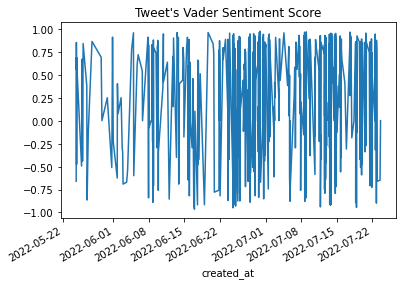

In [20]:
# A all Sentiments over time
#sorting by date
tweets_senators_sentiment_merged.sort_values(by=['created_at'], inplace=True, ascending=True)
#display(tweets_sentiment)

tweets_senators_sentiment_merged['vader_sentiment_score'].plot(
    title=f"Tweet's Vader Sentiment Score");

#tweets_senators_sentiment_merged.head(2)

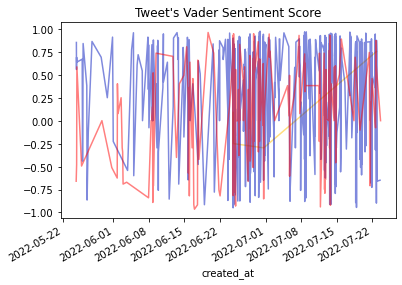

In [21]:
# A all Sentiments over time
#sorting by date
tweets_senators_sentiment_merged.sort_values(by=['created_at'], inplace=True, ascending=True)
#display(tweets_sentiment)

#subgroups
#dem_sentiment = tweets_senators_sentiment_merged.loc[tweets_senators_sentiment_merged['Party'] == "Democrat"] 

tweets_senators_sentiment_merged['vader_sentiment_score'][tweets_senators_sentiment_merged['Party'] == "Independent"].plot(
    title=f"Tweet's Vader Sentiment Score", color=indyellow, kind='line', alpha=0.5);
tweets_senators_sentiment_merged['vader_sentiment_score'][tweets_senators_sentiment_merged['Party'] == "Democrat"].plot(
    title=f"Tweet's Vader Sentiment Score", color=demblue, kind='line', alpha=0.5);
tweets_senators_sentiment_merged['vader_sentiment_score'][tweets_senators_sentiment_merged['Party'] == "Republican"].plot(
    title=f"Tweet's Vader Sentiment Score",  color=repred, kind='line', alpha=0.5);

#tweets_senators_sentiment_merged.head(2)

### VisCount

In [22]:
#count (done) -todo: do it on the right df
#groupby date and name
counts_interm_party=tweets_senators_sentiment_merged[['Party']].copy()
counts_interm_party
tweetcountperday_party=counts_interm_party.groupby([counts_interm_party.index.date, counts_interm_party.Party]).count()
#tweetcountperday_party=tweetcountperday_party.rename(columns={"Party": "count"})
tweetcountperday_party
counts_interm_party

,Party
created_at,
2022-05-24 16:03:21+00:00,Republican
2022-05-24 17:02:15+00:00,Democrat
2022-05-24 17:29:09+00:00,Democrat
2022-05-24 18:01:12+00:00,Democrat
2022-05-24 18:10:59+00:00,Republican
...,...
2022-07-22 23:12:25+00:00,Democrat
2022-07-23 13:40:00+00:00,Democrat
2022-07-23 13:40:00+00:00,Democrat


In [23]:
#count
#groupby party

counts_interm=tweets_senators_sentiment_merged[['Party']].copy()
counts_interm
tweetcountperday=counts_interm.groupby([tweets_senators_sentiment_merged.Party]).count()
tweetcountperday=tweetcountperday.rename(columns={"Party": "count"})

#tweetcountperday = tweetcountperday.reset_index(level='Party')
display(len(tweetcountperday))
display(tweetcountperday.head(10))

3

,count
Party,
Democrat,1008
Independent,5
Republican,318


In [24]:
#count
#groupby date and party

counts_interm_party=tweets_senators_sentiment_merged[['Party']].copy()
counts_interm_party
tweetcountperday_party=counts_interm_party.groupby([tweets_senators_sentiment_merged.index.date, tweets_senators_sentiment_merged.Party]).count()
tweetcountperday_party=tweetcountperday_party.rename(columns={"Party": "count"})

tweetcountperday_party = tweetcountperday_party.reset_index(level='Party')
display(len(tweetcountperday_party))
display(tweetcountperday_party.head(10))

104

,Party,count
2022-05-24,Democrat,4
2022-05-24,Republican,3
2022-05-25,Democrat,2
2022-05-25,Republican,1
2022-05-26,Democrat,3
2022-05-27,Democrat,2
2022-05-29,Democrat,1
2022-05-29,Republican,1
2022-05-30,Democrat,1
2022-05-31,Democrat,2


In [25]:
#count
#groupby date and party and vader_sentiment_phrase

counts_interm_party_phrase=tweets_senators_sentiment_merged[['Party']].copy()
counts_interm_party_phrase
tweetcountperday_party_phrase=counts_interm_party_phrase.groupby([tweets_senators_sentiment_merged.index.date, tweets_senators_sentiment_merged.Party, tweets_senators_sentiment_merged.vader_sentiment_phrase]).count()
tweetcountperday_party_phrase=tweetcountperday_party_phrase.rename(columns={"Party": "count"})

tweetcountperday_party_phrase = tweetcountperday_party_phrase.reset_index(level=['Party', 'vader_sentiment_phrase'])

tweetcountperday_party_phrase=tweetcountperday_party_phrase.rename(columns={"vader_sentiment_phrase": "Sentiment"})
display(len(tweetcountperday_party_phrase))
display(tweetcountperday_party_phrase.head(10))

201

,Party,Sentiment,count
2022-05-24,Democrat,positive,4
2022-05-24,Republican,negative,2
2022-05-24,Republican,positive,1
2022-05-25,Democrat,negative,1
2022-05-25,Democrat,positive,1
2022-05-25,Republican,negative,1
2022-05-26,Democrat,negative,1
2022-05-26,Democrat,positive,2
2022-05-27,Democrat,negative,1
2022-05-27,Democrat,positive,1


In [27]:
#descriptives
display(rp.summary_cont(tweetcountperday_party['count'].groupby([tweetcountperday_party.index])))


/Users/martinfaschingbauer/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/martinfaschingbauer/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,N,Mean,SD,SE,95% Conf.,Interval
2022-05-24,2,3.5000,0.7071,0.5000,-2.8531,9.8531
2022-05-25,2,1.5000,0.7071,0.5000,-4.8531,7.8531
2022-05-26,1,3.0000,NaN,NaN,NaN,NaN
2022-05-27,1,2.0000,NaN,NaN,NaN,NaN
2022-05-29,2,1.0000,0.0000,0.0000,NaN,NaN
2022-05-30,1,1.0000,NaN,NaN,NaN,NaN
2022-05-31,2,1.5000,0.7071,0.5000,-4.8531,7.8531
2022-06-01,1,3.0000,NaN,NaN,NaN,NaN
2022-06-02,1,4.0000,NaN,NaN,NaN,NaN
2022-06-03,2,1.0000,0.0000,0.0000,NaN,NaN


104

,Party,Sentiment,count
2022-05-24,Democrat,positive,4
2022-05-24,Republican,negative,2
2022-05-24,Republican,positive,1
2022-05-25,Democrat,negative,1
2022-05-25,Democrat,positive,1
...,...,...,...
2022-07-22,Republican,negative,2
2022-07-22,Republican,neutral,2
2022-07-22,Republican,positive,6
2022-07-23,Democrat,negative,2


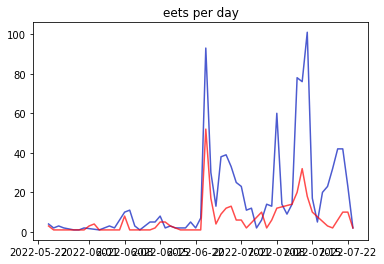

In [28]:
#tweet count per day and party
display(len(tweetcountperday_party))

tweetcountperday_party['count'][tweetcountperday_party['Party'] == "Democrat"].plot(
    title="Tweets per day", color=demblue, kind='line', alpha=0.7);
tweetcountperday_party['count'][tweetcountperday_party['Party'] == "Republican"].plot(
    title="eets per day", color=repred, kind='line', alpha=0.7);
#reset_indx1['count'][reset_indx1['Party'] == "Independent"].plot(
#    title="Tweets per day", color=indyellow, kind='line', alpha=0.5);

tweetcountperday_party_phrase

201

,Party,Sentiment,count
2022-05-24,Democrat,positive,4
2022-05-24,Republican,negative,2
2022-05-24,Republican,positive,1


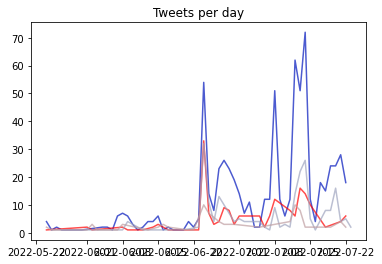

In [29]:
#tweet count per day, party and phrase
display(len(tweetcountperday_party_phrase))

#tweetcountperday_party_phrase=tweetcountperday_party_phrase.rename(columns={"vader_sentiment_phrase": "Sentiment"})


#crosstab


display(tweetcountperday_party_phrase.head(3))

tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Democrat") & (tweetcountperday_party_phrase['Sentiment'] == "positive")].plot(
    title="Tweets per day", color=demblue, kind='line', alpha=0.7);
tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Republican") & (tweetcountperday_party_phrase['Sentiment'] == "positive")].plot(
    title="Tweets per day", color=repred, kind='line', alpha=0.7);

tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Democrat") & (tweetcountperday_party_phrase['Sentiment'] == "negative")].plot(
    title="Tweets per day", color=demgrey, kind='line', alpha=0.7);
tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Republican") & (tweetcountperday_party_phrase['Sentiment'] == "negative")].plot(
    title="Tweets per day", color=repgrey, kind='line', alpha=0.7);
#reset_indx1['count'][reset_indx1['Party'] == "Independent"].plot(
#    title="Tweets per day", color=indyellow, kind='line', alpha=0.5);



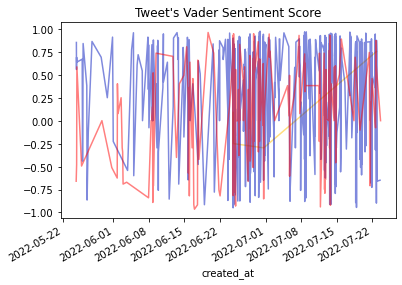

In [30]:
tweets_senators_sentiment_merged['vader_sentiment_score'][tweets_senators_sentiment_merged['Party'] == "Independent"].plot(
    title=f"Tweet's Vader Sentiment Score", color=indyellow, kind='line', alpha=0.5);
tweets_senators_sentiment_merged['vader_sentiment_score'][tweets_senators_sentiment_merged['Party'] == "Democrat"].plot(
    title=f"Tweet's Vader Sentiment Score", color=demblue, kind='line', alpha=0.5);
tweets_senators_sentiment_merged['vader_sentiment_score'][tweets_senators_sentiment_merged['Party'] == "Republican"].plot(
    title=f"Tweet's Vader Sentiment Score",  color=repred, kind='line', alpha=0.5);

#tweets_senators_sentiment_merged.head(2)

<AxesSubplot:title={'center':'positive Tweets per day'}>

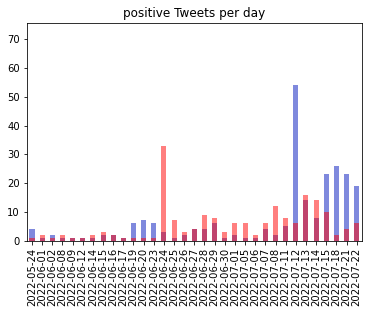

In [31]:
#bar plot of sentiment counts

tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Democrat") & (tweetcountperday_party_phrase['Sentiment'] == "positive")].plot(
    title="positive Tweets per day", color=demblue, kind='bar', alpha=0.5)

tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Republican") & (tweetcountperday_party_phrase['Sentiment'] == "positive")].plot(
    title="positive Tweets per day", color=repred, kind='bar', alpha=0.5)#.invert_yaxis()

#sollte nebeneinander sein


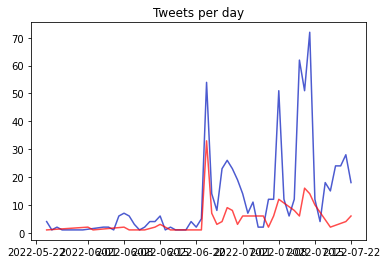

In [32]:
#rep and dom - positive sentiment count over time
tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Democrat") & (tweetcountperday_party_phrase['Sentiment'] == "positive")].plot(
    title="Tweets per day", color=demblue, kind='line', alpha=0.7);
tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Republican") & (tweetcountperday_party_phrase['Sentiment'] == "positive")].plot(
    title="Tweets per day", color=repred, kind='line', alpha=0.7);


<BarContainer object of 201 artists>

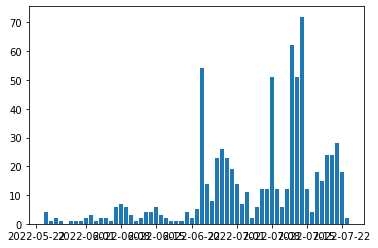

In [45]:
plt.bar(tweetcountperday_party_phrase.index, tweetcountperday_party_phrase["count"])

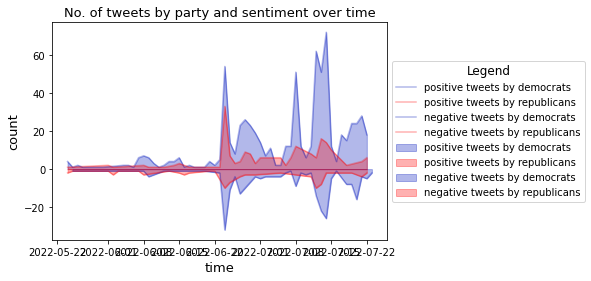

In [33]:
dempos=tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Democrat") & (tweetcountperday_party_phrase['Sentiment'] == "positive")]
reppos=tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Republican") & (tweetcountperday_party_phrase['Sentiment'] == "positive")]
demneg=tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Democrat") & (tweetcountperday_party_phrase['Sentiment'] == "negative")]
repneg=tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Republican") & (tweetcountperday_party_phrase['Sentiment'] == "negative")]


plt.plot(dempos.index, dempos, label = 'positive tweets by democrats', color=demblue, alpha=0.3)
plt.fill_between(dempos.index, dempos, label = 'positive tweets by democrats', color=demblue,alpha=0.3)

plt.plot(reppos.index, reppos, label = 'positive tweets by republicans', color=repred, alpha=0.3)
plt.fill_between(reppos.index, reppos, label = 'positive tweets by republicans', color=repred, alpha=0.3)

plt.plot(demneg.index, demneg*-1, label = 'negative tweets by democrats', color=demblue, alpha=0.3)
plt.fill_between(demneg.index, demneg*-1, label = 'negative tweets by democrats', color=demblue, alpha=0.3)

plt.plot(repneg.index, repneg*-1, label = 'negative tweets by republicans', color=repred, alpha=0.3)
plt.fill_between(repneg.index, repneg*-1, label = 'negative tweets by republicans', color=repred, alpha=0.3)

plt.title("No. of tweets by party and sentiment over time", fontsize=13)
plt.xlabel("time", fontsize=13)
plt.ylabel("count", fontsize=13)
plt.legend(title='Legend',title_fontsize=12,loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


# colors
demblue = "#0015BC"
repred = "#FF0000"
demgrey = "#9EA4BF"
repgrey = "#BF9EA2"
indyellow="#FFBF00"

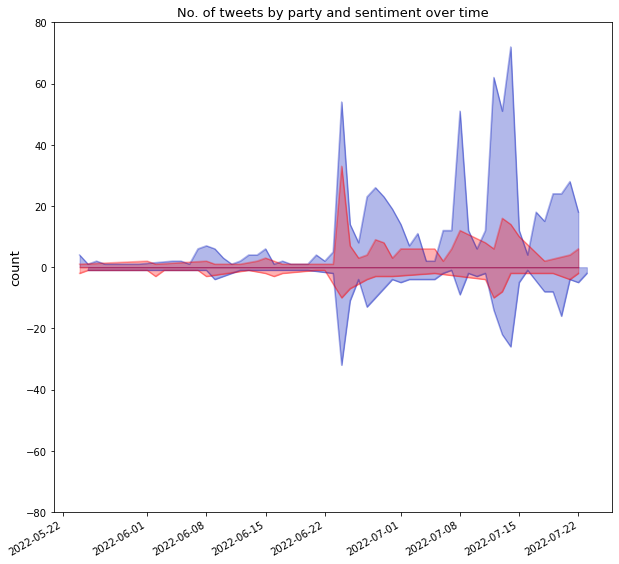

In [34]:
#number of positiv and negative tweets per day

fig, ax = plt.subplots(figsize=(10, 10))

dempos=tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Democrat") & (tweetcountperday_party_phrase['Sentiment'] == "positive")]
reppos=tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Republican") & (tweetcountperday_party_phrase['Sentiment'] == "positive")]
demneg=tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Democrat") & (tweetcountperday_party_phrase['Sentiment'] == "negative")]
repneg=tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Republican") & (tweetcountperday_party_phrase['Sentiment'] == "negative")]

ax.plot(dempos.index, dempos, label = 'positive tweets by democrats', color=demblue, alpha=0.3)
ax.fill_between(dempos.index, dempos, label = 'positive tweets by democrats', color=demblue,alpha=0.3)

ax.plot(reppos.index, reppos, label = 'positive tweets by republicans', color=repred, alpha=0.3)
ax.fill_between(reppos.index, reppos, label = 'positive tweets by republicans', color=repred, alpha=0.3)

ax.plot(demneg.index, demneg*-1, label = 'negative tweets by democrats', color=demblue, alpha=0.3)
ax.fill_between(demneg.index, demneg*-1, label = 'negative tweets by democrats', color=demblue, alpha=0.3)

ax.plot(repneg.index, repneg*-1, label = 'negative tweets by republicans', color=repred, alpha=0.3)
ax.fill_between(repneg.index, repneg*-1, label = 'negative tweets by republicans', color=repred, alpha=0.3)


ax.grid(False) 
plt.title("No. of tweets by party and sentiment over time", fontsize=13)
plt.xlabel("", fontsize=13)
plt.ylabel("count", fontsize=13)
ax.set_ylim([-80, 80])
#plt.legend(title='Legend',title_fontsize=12,loc='center left', bbox_to_anchor=(1, 0.5))
fig.autofmt_xdate() 
plt.show()
fig.savefig('results/tweetsperday_phrase.png', dpi=300)

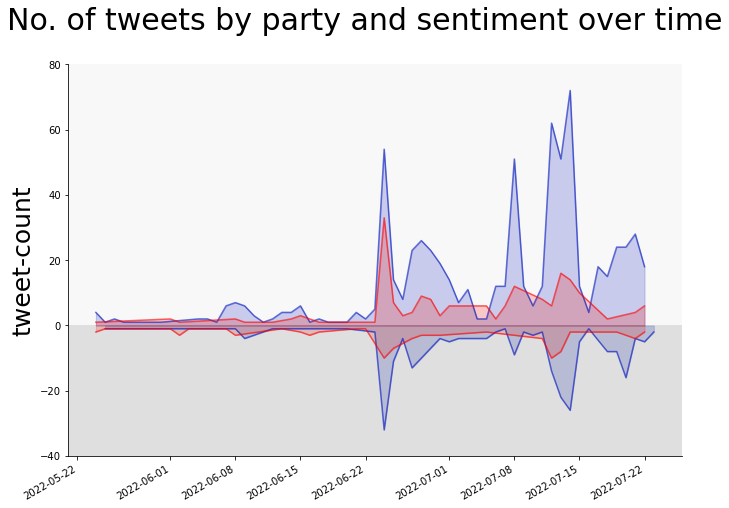

In [55]:
#number of positiv and negative tweets per day
#same as above nur mehr lesbar auf ppt


fig, ax = plt.subplots(figsize=(11, 8))

dempos=tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Democrat") & (tweetcountperday_party_phrase['Sentiment'] == "positive")]
reppos=tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Republican") & (tweetcountperday_party_phrase['Sentiment'] == "positive")]
demneg=tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Democrat") & (tweetcountperday_party_phrase['Sentiment'] == "negative")]
repneg=tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Republican") & (tweetcountperday_party_phrase['Sentiment'] == "negative")]

ax.plot(dempos.index, dempos, label = 'positive tweets by democrats', color=demblue, alpha=0.6)
ax.fill_between(dempos.index, dempos, label = None, color=demblue,alpha=0.2)

ax.plot(reppos.index, reppos, label = 'positive tweets by republicans', color=repred, alpha=0.6)
ax.fill_between(reppos.index, reppos, label = None, color=repred, alpha=0.2)

ax.plot(demneg.index, demneg*-1, label = 'negative tweets by democrats', color=demblue, alpha=0.6)
ax.fill_between(demneg.index, demneg*-1, label = None, color=demblue, alpha=0.2)

ax.plot(repneg.index, repneg*-1, label = 'negative tweets by republicans', color=repred, alpha=0.6)
ax.fill_between(repneg.index, repneg*-1, label = None, color=repred, alpha=0.2)


ax.grid(False) 
plt.title(" ", fontsize=30)
plt.suptitle("No. of tweets by party and sentiment over time", fontsize=30)
plt.xlabel("", fontsize=25)
plt.ylabel("tweet-count", fontsize=25)
ax.FontSize = 25
ax.set_ylim([-40, 80])
#plt.legend(title='Legend',title_fontsize=12,loc='best', bbox_to_anchor=(1, 0.5))
fig.autofmt_xdate() 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axhspan(0, 80, facecolor='gray', alpha=0.05)
ax.axhspan(0, -40, facecolor='gray', alpha=0.25)
plt.show()
fig.savefig('results/tweetsperday_phrase_plot2.png', dpi=300)

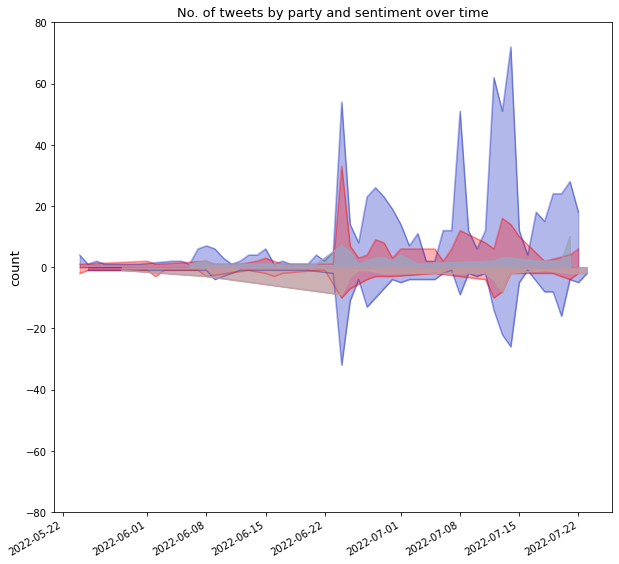

In [36]:
#plus neutral tweets
fig, ax = plt.subplots(figsize=(10, 10))

dempos=tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Democrat") & (tweetcountperday_party_phrase['Sentiment'] == "positive")]
reppos=tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Republican") & (tweetcountperday_party_phrase['Sentiment'] == "positive")]
demneg=tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Democrat") & (tweetcountperday_party_phrase['Sentiment'] == "negative")]
repneg=tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Republican") & (tweetcountperday_party_phrase['Sentiment'] == "negative")]
demneu=tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Democrat") & (tweetcountperday_party_phrase['Sentiment'] == "neutral")]
repneu=tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Republican") & (tweetcountperday_party_phrase['Sentiment'] == "neutral")]


ax.plot(dempos.index, dempos, label = 'positive tweets by democrats', color=demblue, alpha=0.3)
ax.fill_between(dempos.index, dempos, label = 'positive tweets by democrats', color=demblue,alpha=0.3)

ax.plot(reppos.index, reppos, label = 'positive tweets by republicans', color=repred, alpha=0.3)
ax.fill_between(reppos.index, reppos, label = 'positive tweets by republicans', color=repred, alpha=0.3)

ax.plot(demneg.index, demneg*-1, label = 'negative tweets by democrats', color=demblue, alpha=0.3)
ax.fill_between(demneg.index, demneg*-1, label = 'negative tweets by democrats', color=demblue, alpha=0.3)

ax.plot(repneg.index, repneg*-1, label = 'negative tweets by republicans', color=repred, alpha=0.3)
ax.fill_between(repneg.index, repneg*-1, label = 'negative tweets by republicans', color=repred, alpha=0.3)


ax.plot(demneu.index, demneu*1, label = 'neutral tweets by republicans', color=demgrey, alpha=0.8)
ax.fill_between(demneu.index, demneu*1, label = 'neutral tweets by republicans', color=demgrey, alpha=0.8)

ax.plot(repneu.index, repneu*-1, label = 'neutral tweets by republicans', color=repgrey, alpha=0.8)
ax.fill_between(repneu.index, repneu*-1, label = 'neutral tweets by republicans', color=repgrey, alpha=0.8)

ax.grid(False) 
plt.title("No. of tweets by party and sentiment over time", fontsize=13)
plt.xlabel("", fontsize=13)
plt.ylabel("count", fontsize=13)
ax.set_ylim([-80, 80])
#plt.legend(title='Legend',title_fontsize=12,loc='center left', bbox_to_anchor=(1, 0.5))
fig.autofmt_xdate() 
plt.show()

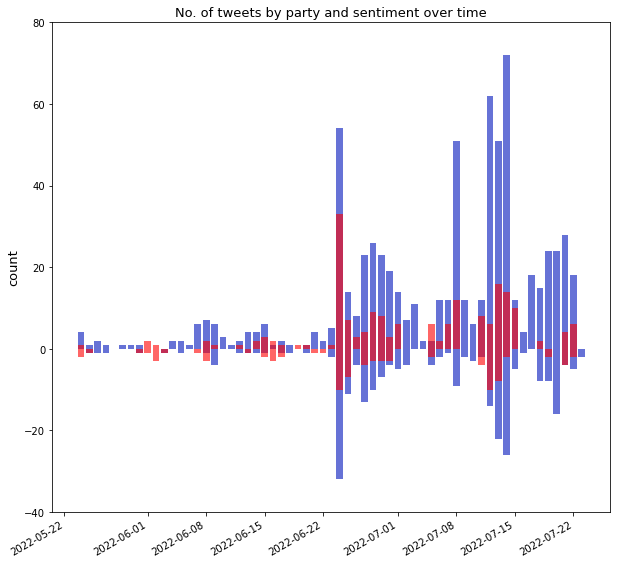

In [38]:
#plus neutral tweets
fig, ax = plt.subplots(figsize=(10, 10))

dempos=tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Democrat") & (tweetcountperday_party_phrase['Sentiment'] == "positive")]
reppos=tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Republican") & (tweetcountperday_party_phrase['Sentiment'] == "positive")]
demneg=tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Democrat") & (tweetcountperday_party_phrase['Sentiment'] == "negative")]
repneg=tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Republican") & (tweetcountperday_party_phrase['Sentiment'] == "negative")]
demneu=tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Democrat") & (tweetcountperday_party_phrase['Sentiment'] == "neutral")]
repneu=tweetcountperday_party_phrase['count'][(tweetcountperday_party_phrase['Party'] == "Republican") & (tweetcountperday_party_phrase['Sentiment'] == "neutral")]


ax.bar(dempos.index, dempos, label = 'positive tweets by democrats', color=demblue, alpha=0.6)
#ax.fill_between(dempos.index, dempos, label = 'positive tweets by democrats', color=demblue,alpha=0.3)

ax.bar(reppos.index, reppos, label = 'positive tweets by republicans', color=repred, alpha=0.6)
#ax.fill_between(reppos.index, reppos, label = 'positive tweets by republicans', color=repred, alpha=0.3)

ax.bar(demneg.index, demneg*-1, label = 'negative tweets by democrats', color=demblue, alpha=0.6)
#ax.fill_between(demneg.index, demneg*-1, label = 'negative tweets by democrats', color=demblue, alpha=0.3)

ax.bar(repneg.index, repneg*-1, label = 'negative tweets by republicans', color=repred, alpha=0.6)
#ax.fill_between(repneg.index, repneg*-1, label = 'negative tweets by republicans', color=repred, alpha=0.3)


#ax.bar(demneu.index, demneu*1, label = 'neutral tweets by republicans', color=demgrey, alpha=0.8)
#ax.fill_between(demneu.index, demneu*1, label = 'neutral tweets by republicans', color=demgrey, alpha=0.8)

#ax.bar(repneu.index, repneu*-1, label = 'neutral tweets by republicans', color=repgrey, alpha=0.8)
#ax.fill_between(repneu.index, repneu*-1, label = 'neutral tweets by republicans', color=repgrey, alpha=0.8)

ax.grid(False) 
plt.title("No. of tweets by party and sentiment over time", fontsize=13)
plt.xlabel("", fontsize=13)
plt.ylabel("count", fontsize=13)
ax.set_ylim([-40, 80])
#plt.legend(title='Legend',title_fontsize=12,loc='center left', bbox_to_anchor=(1, 0.5))
fig.autofmt_xdate() 
plt.show()
fig.savefig('results/tweetsperday_phrase_bar', dpi=300)